In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [12]:
ker = SourceModule(
    """
    #define x (threadIdx.x)

    __device__ void tall_matrix_multiply(float *matrix, float *vector, float *out, int width) {
        int index = x * width;

        for (int i = 0; i < width; i++) {
            out[x] += matrix[index + i] * vector[i];
        }
    }

    __device__ void atomic_sub(float *vector1, float *vector2, int width) {
        
        vector1[x] -= vector2[x];
    }

    __device__ void wide_matrix_multiply(float *matrix, float *vector, float *grad, int width, int length) {
        int wideness = length / width;
        int row = x / wideness;
        int col = x % wideness;
        int index1 = row * length;
        int index2 = row * wideness;

        for (int i = 0; i < width; i++) {
            int k = col * width + i;

            grad[index2 + col] += matrix[index1 + k] * vector[k];
        }

        if (x < width) {
            int index3 = wideness * x;

            for (int i = 1; i < wideness; i++) {
                grad[index3] += grad[index3 + i];
            }
        }
    }

    __device__ void update(float *vector, float *grad, float learning_rate, int width, int length) {
        int wideness = length / width;

        if (x < width) {
            int index3 = x * wideness;

            vector[x] -= grad[index3] * learning_rate;
        }
    }

    __global__ void main_function(float *matrix1, float *matrix2, float *vector1, float *vector2, float *out, float *grad, int width, int length, float learning_rate) {

        // optimize
        tall_matrix_multiply(matrix1, vector1, out, width);

        __syncthreads();

        atomic_sub(out, vector2, width);
        
        __syncthreads();
        
        wide_matrix_multiply(matrix2, out, grad, width, length);
        
        __syncthreads();

        update(vector1, grad, learning_rate, width, length);

        __syncthreads();

    }
    """
)

calculate = ker.get_function("main_function")

Error in GPU: 9.399492263793945
Error in CPU: 9.33279037475586
How does it take in GPU?: 3.24539
[17.87902069  9.4268837   9.4199295   9.4170599   9.41428757  9.41160774
  9.40901852  9.40651417  9.40409756  9.40175533]


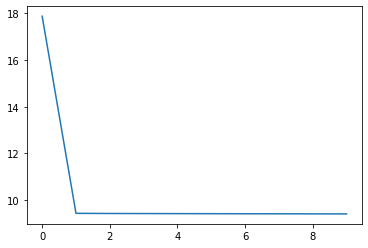

In [13]:
length = 1000
width = 20
n = 10
wideness = np.int32(length / width)
error_list = np.zeros((n))

lr = np.float32(2e-4)

A = np.float32(np.random.rand(length,width))
b = np.float32(np.random.rand(length))
theta = np.float32(np.zeros((width)))
out = np.float32(np.zeros_like(b))
grad = np.float32(np.zeros((width,wideness)))

A1_gpu = gpuarray.to_gpu(A.reshape(length*width))
A2_gpu = gpuarray.to_gpu(A.T.reshape(length*width))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.to_gpu(out)
grad_gpu = gpuarray.to_gpu(grad.reshape(width*wideness))

init_vec1 = gpuarray.empty_like(out_gpu)
init_vec2 = gpuarray.empty_like(grad_gpu)

t1 = time()
for i in range(n):
    theta = theta_gpu.get()
    error = np.linalg.norm(np.dot(A, theta) - b)
    error_list[i] = error

    out_gpu[:] = init_vec1[:]
    grad_gpu[:] = init_vec2[:]
    
    calculate(A1_gpu, A2_gpu, theta_gpu, b_gpu, out_gpu, grad_gpu, np.int32(width), np.int32(length), lr, block=(length,1,1), grid=(1,1,1))

t2 = time()
theta = theta_gpu.get()

t3 = time()
theta_cpu = np.linalg.lstsq(A, b, rcond=None)[0]
t4 = time()

error_gpu = np.linalg.norm(np.dot(A, theta) - b)
error_cpu = np.linalg.norm(np.dot(A, theta_cpu) - b)

print(f"Error in GPU: {error_gpu}")
print(f"Error in CPU: {error_cpu}")
print(f"How does it take in GPU?: {round((t2 - t1) / (t4 - t3), 5)}")
print(error_list)

plt.plot(error_list)
plt.show()

Error in GPU: 6.616381645202637
Error in CPU: 6.450214862823486
How does it take in GPU?: 89.64706


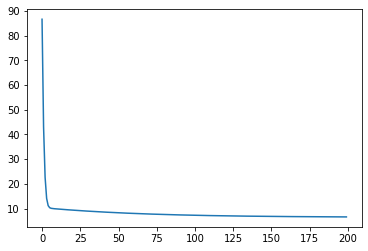

In [14]:
length = 500
width = 20
n = 200
wideness = np.int32(length / width)
error_list = np.zeros((n))

lr = np.float32(2e-4)

A = np.float32(np.random.rand(length,width))
b = np.float32(np.random.rand(length))
theta = np.float32(np.random.rand((width)))
out = np.float32(np.zeros_like(b))
grad = np.float32(np.zeros((width,wideness)))

A1_gpu = gpuarray.to_gpu(A.reshape(length*width))
A2_gpu = gpuarray.to_gpu(A.T.reshape(length*width))
b_gpu = gpuarray.to_gpu(b)
theta_gpu = gpuarray.to_gpu(theta)
out_gpu = gpuarray.to_gpu(out)
grad_gpu = gpuarray.to_gpu(grad.reshape(width*wideness))

init_vec1 = gpuarray.empty_like(out_gpu)
init_vec2 = gpuarray.empty_like(grad_gpu)

t1 = time()
for i in range(n):
    theta = theta_gpu.get()
    error = np.linalg.norm(np.dot(A, theta) - b)
    error_list[i] = error

    out_gpu[:] = init_vec1[:]
    grad_gpu[:] = init_vec2[:]
    
    calculate(A1_gpu, A2_gpu, theta_gpu, b_gpu, out_gpu, grad_gpu, np.int32(width), np.int32(length), lr, block=(length,1,1), grid=(1,1,1))

t2 = time()
theta = theta_gpu.get()

t3 = time()
theta_cpu = np.linalg.lstsq(A, b, rcond=None)[0]
t4 = time()

error_gpu = np.linalg.norm(np.dot(A, theta) - b)
error_cpu = np.linalg.norm(np.dot(A, theta_cpu) - b)

print(f"Error in GPU: {error_gpu}")
print(f"Error in CPU: {error_cpu}")
print(f"How does it take in GPU?: {round((t2 - t1) / (t4 - t3), 5)}")

plt.plot(error_list)
plt.show()

In [15]:
theta-theta_cpu

array([ 0.01082666, -0.0598347 , -0.1051149 , -0.03918479,  0.05918388,
       -0.0211704 ,  0.02123076, -0.05219542,  0.00321758, -0.04443711,
       -0.03241995, -0.03201664,  0.02371903,  0.07325439,  0.04280927,
        0.09047519,  0.04931128,  0.01964516, -0.07107139,  0.06853197],
      dtype=float32)

no answer

# Cuda Streams

In [3]:
num_arrays = 200
array_len = 1024**2

In [5]:
ker = SourceModule(
    """
    __global__ void mult_ker(float *array, int array_len)
    {
        int thd = blockIdx.x * blockDim.x + threadIdx.x;
        int num_iters = array_len / blockDim.x;

        for (int j = 0; j < num_iters; j++) {
            int i = j *  blockDim.x + thd;

            for (int k = 0; k < 50; k++) {
                array[i] *= 2.0;
                array[i] /= 2.0;
            }
        }
    }
    """
)

mult_ker = ker.get_function("mult_ker")

In [7]:
data = []
data_gpu = []
gpu_out = []

# generate random arrays.
for _ in range(num_arrays):
    data.append(np.random.randn(array_len).astype("float32"))

t_start = time()

for k in range(num_arrays):
    data_gpu.append(gpuarray.to_gpu(data[k]))

for k in range(num_arrays):
    mult_ker(data_gpu[k], np.int32(array_len), block=(64,1,1), grid=(1,1,1))

for k in range(num_arrays):
    gpu_out.append(data_gpu[k].get())

t_end = time()

for k in range(num_arrays):
    assert (np.allclose(gpu_out[k], data[k]))

print(f"Total time: {t_end - t_start}")

Total time: 2.696885347366333


In [13]:
data = []
data_gpu = []
gpu_out = []
streams = []

# generate random arrays.
for _ in range(num_arrays):
    data.append(np.random.randn(array_len).astype("float32"))
    
for _ in range(num_arrays):
    streams.append(drv.Stream())

t_start = time()

for k in range(num_arrays):
    data_gpu.append(gpuarray.to_gpu_async(data[k], stream=streams[k]))

for k in range(num_arrays):
    mult_ker(data_gpu[k], np.int32(array_len), block=(64,1,1), grid=(1,1,1), stream=streams[k])

for k in range(num_arrays):
    gpu_out.append(data_gpu[k].get_async(stream=streams[k]))

t_end = time()

for k in range(num_arrays):
    assert (np.allclose(gpu_out[k], data[k]))

print(f"Total time: {t_end - t_start}")

Total time: 0.4987301826477051


# Concurrent conway's game of life using CUDA Streams

In [14]:
ker = SourceModule(
    """
    #define _X (threadIdx.x + blockIdx.x * blockDim.x)
    #define _Y (threadIdx.y + blockIdx.y * blockDim.y)

    #define _WIDTH (blockDim.x * gridDim.x)
    #define _HEIGHT (blockDim.y * gridDim.y)

    #define _XM(x) ((x + _WIDTH) % _WIDTH)
    #define _YM(y) ((y + _HEIGHT) % _HEIGHT)

    #define  _INDEX(x,y) (_XM(x) + _YM(y) * _WIDTH)

    __device__ int nbrs(int x, int y, int *in)
    {
        return (in[_INDEX(x-1,y+1)] + in[_INDEX(x-1,y)] + in[_INDEX(x-1,y-1)]\
              + in[_INDEX(x  ,y+1)] + in[_INDEX(x  ,y)] + in[_INDEX(x  ,y-1)]\
              + in[_INDEX(x+1,y+1)] + in[_INDEX(x+1,y)] + in[_INDEX(x+1,y-1)]);
    }

    __global__ void conway_ker(int *lattice_out, int *lattice)
    {
        // x, y are the appropriate values for the cell covered by this thread
        int x = _X;
        int y = _Y;

        // count the number of neighbors around the current cell
        int n = nbrs(x, y, lattice);

        // if the current cell is alive, then determine if it lives or dies for the next generation.
        if (lattice[_INDEX(x,y)] == 1)
            switch(n)
        {
            //if the cell is alive: it remains alive only if it has 2 or 3 neighbors.
            case 2:
            case 3: lattice_out[_INDEX(x,y)] = 1;
                    break;
            default: lattice_out[_INDEX(x,y)] = 0;
        }
        else if (lattice[_INDEX(x,y)] == 0)
            switch(n)
        {
            // a dead cell comes to life only if it has 3 neighbors that are alive.
            case 3: lattice_out[_INDEX(x,y)] = 1;
                    break;
            default: lattice_out[_INDEX(x,y)] = 0;
        }
    }
    """
)

conway_ker = ker.get_function("conway_ker")

In [21]:
def update_gpu(frameNum, imgs, newLattices_gpu, lattices_gpu, N, streams, num_concurrent):

    for k in range(num_concurrent):
        conway_ker(newLattices_gpu[k], lattices_gpu[k],  block=(32,32,1), grid=(int(N/32),int(N/32),1), stream=streams[k])

    imgs[k].set_data(newLattices_gpu[k].get_async(stream=streams[k]))
    lattices_gpu[k].set_async(newLattices_gpu[k], stream=streams[k])
    
    return imgs

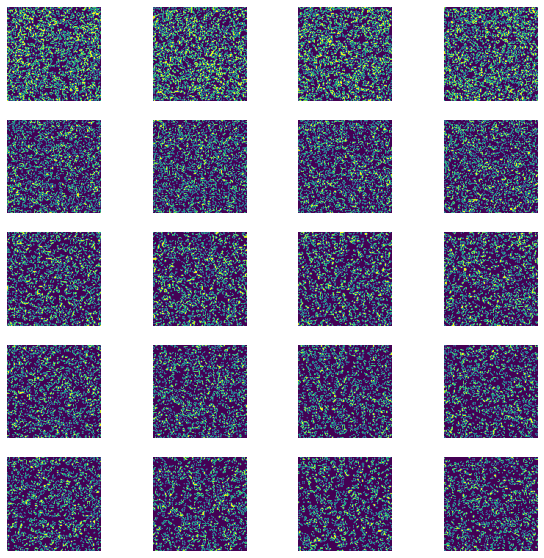

In [56]:
if __name__ == "__main__":
    # set lattice size
    N = 128
    num_concurrent = 4

    streams = []
    lattices_gpu = []
    newLattices_gpu = []

    for k in range(num_concurrent):
        streams.append(drv.Stream())
        lattice = np.int32(np.random.choice([0,1], N*N, p=[0.75,0.25]).reshape(N,N))
        lattices_gpu.append(gpuarray.to_gpu(lattice))
        newLattices_gpu.append(gpuarray.empty_like(lattices_gpu[k]))

    fig, ax = plt.subplots(nrows=5, ncols=num_concurrent, figsize=(10,10))
    imgs = []

    for k in range(num_concurrent):
        imgs.append(lattices_gpu[k].get_async(stream=streams[k]))

    t = 0
    while t < 5:
        
        for k in range(num_concurrent):

            conway_ker(newLattices_gpu[k], lattices_gpu[k], block=(32,32,1), grid=(int(N/32),int(N/32),1), stream=streams[k])

            imgs[k] = newLattices_gpu[k].get_async(stream=streams[k])
            lattices_gpu[k].set_async(newLattices_gpu[k], stream=streams[k])
        
            ax[t,k].imshow(imgs[k])
            ax[t,k].axis("off")

        t += 1
            
    plt.show()

# Stream...?

In [31]:
ker2 = SourceModule(
    """
    #define x (threadIdx.x)

    __global__ void main_function(float *matrix, float *theta, float *vector, float *out, float *grad, int width, float learning_rate) {

        // optimize
        // calculate Ax.
        for (int i = 0; i < width; i++) {
                out[x] += matrix[x*width+i] * theta[i];
        }

        __syncthreads();
        
        // calculate Ax - b.
        out[x] -= vector[x];
        
        __syncthreads();
        
        // calculate A.T(Ax - b).
        for (int i = 0; i < width; i++) {
                grad[x] += matrix[i*width+x] * out[i];
        }
        
        __syncthreads();

        // update theta.
        theta[x] -= grad[x] * learning_rate;

        __syncthreads();
        
    }
    """
)

calculate = ker2.get_function("main_function")

In [46]:
A = np.float32(np.random.rand(20,20))
b = np.float32(np.random.rand(20))
theta = np.float32(np.random.rand(20))
out = np.float32(np.zeros(20))
grad = np.float32(np.zeros(20))
width = 20
learning_rate = 2e-4

A_gpu = gpuarray.to_gpu(A.reshape(20*20))
b_gpu = gpuarray.to_gpu(b)
t_gpu = gpuarray.to_gpu(theta)
o_gpu = gpuarray.to_gpu(out)
g_gpu = gpuarray.to_gpu(grad)

calculate(A_gpu, t_gpu, b_gpu, o_gpu, g_gpu, np.int32(width), np.float32(learning_rate), block=(20,1,1), grid=(1,1,1))

theta_gpu = t_gpu.get()
theta -= learning_rate * np.dot(A.T,(np.dot(A,theta) - b))

print(np.allclose(theta_gpu, theta))

False


In [48]:
theta_gpu

array([0.20601451, 0.321904  , 0.30341086, 0.58572656, 0.45305282,
       0.5610204 , 0.174437  , 0.9578452 , 0.96384674, 0.82360786,
       0.46784934, 0.11469972, 0.2858799 , 0.42142326, 0.74329567,
       0.42371097, 0.55588037, 0.8574904 , 0.54905623, 0.6334339 ],
      dtype=float32)

In [47]:
theta

array([0.19634938, 0.31411323, 0.29540825, 0.5773572 , 0.4445855 ,
       0.5524357 , 0.16346745, 0.950115  , 0.9534478 , 0.81462896,
       0.4565849 , 0.10760769, 0.2760598 , 0.41288167, 0.73569745,
       0.41409746, 0.5476737 , 0.8500401 , 0.5399335 , 0.6232617 ],
      dtype=float32)

In [49]:
length = 400
width = 20
num_streams = int(length / width)

In [58]:
As = []
bs = []
ts = []
os = []
gs = []
As_gpu = []
bs_gpu = []
ts_gpu = []
os_gpu = []
gs_gpu = []
gpu_out = []
streams = []

lr = np.float32(2e-4)

A = np.float32(np.random.rand(length,width)).reshape(length*width)
b = np.float32(np.random.rand(length))
theta = np.float32(np.random.rand((width)))
out = np.float32(np.zeros(width))
grad = np.float32(np.zeros((width)))

init_out = gpuarray.to_gpu(np.float32(np.zeros_like(out)))
init_grad = gpuarray.to_gpu(np.float32(np.zeros_like(grad)))

for k in range(num_streams):
    index = k*num_streams
    As.append(A[index:index+width])
    bs.append(b[index:index+width])
    ts.append(theta)
    os.append(out)
    gs.append(grad)
    
for _ in range(num_streams):
    streams.append(drv.Stream())

t_start = time()

for k in range(num_streams):
    As_gpu.append(gpuarray.to_gpu_async(As[k], stream=streams[k]))
    bs_gpu.append(gpuarray.to_gpu_async(bs[k], stream=streams[k]))
    ts_gpu.append(gpuarray.to_gpu_async(ts[k], stream=streams[k]))
    os_gpu.append(gpuarray.to_gpu_async(os[k], stream=streams[k]))
    gs_gpu.append(gpuarray.to_gpu_async(gs[k], stream=streams[k]))

t_start2 = time()
for iter in range(5):
    for k in range(num_streams):
        calculate(As_gpu[k], ts_gpu[k], bs_gpu[k], os_gpu[k], gs_gpu[k], np.int32(width), lr, block=(width,1,1), grid=(1,1,1), stream=streams[k])
        os_gpu[k][:] = init_out[:]
        gs_gpu[k][:] = init_grad[:]
t_end2 = time()

for k in range(num_streams):
    gpu_out.append(ts_gpu[k].get_async(stream=streams[k]))

t_end = time()

opt_t = np.zeros((width))

error_list = np.zeros(num_streams)

for k in range(num_streams):
        error_list[k] = np.linalg.norm(np.dot(As[k], gpu_out[k]) - bs[k])

print(t_end - t_start)
print(t_end2 - t_start2)
print(error_list)

0.027698278427124023
0.017891407012939453
[21.52331352 16.59296036 15.21754742 14.42829323 13.56462383 16.15035629
 22.48003387 17.78919983 10.87421703 16.64304733 16.33917999 22.61803055
 23.18770599 19.24037743 14.29328346 14.99109364 26.47805023 12.98411751
 25.3329277  20.29478455]


In [51]:
t1 = time()
opt_t_cpu = np.linalg.lstsq(A.reshape(length,width),b, rcond=None)[0]
t2 = time()
print(t2 - t1)

0.0021560192108154297
